In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TrialSolution import TrialSolution

## Example 3

$\frac{d^2}{dx^2}\Psi+\frac{1}{5}\frac{d}{dx}\Psi+\Psi=-\frac{1}{5}\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$, $\frac{d}{dx}\Psi(0)=1$ and domain $x\in[0,2]$

In [2]:
X_train = np.arange(0, 2., 0.2) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 2., 0.01) + 1e-8
X_test = X_test.reshape(-1,1) 

In [3]:
def const_function(c):
    def function(X):
        return tf.constant(c, dtype='float64', shape=(X.shape[0],1))
    return function
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':const_function(0.)},
        {'variable':0, 'value':0, 'type':'neumann',
        'function':const_function(1.)}]

The trial solution for this case is $\Psi(x)=x + x^2N(x)$.
The first function below is the function $A(x)=x$
and the second function is the function $B(x)=x^2$.
Though, in our case, the trial solution is generated automatically from the initial conditions.

In [14]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1, equation_type='ODE')

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [15]:
def diff_loss(network, inputs):
  # Compute the gradients
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
  
  # Compute the loss
  loss = tf.square(laplace + tf.constant(0.2, dtype='float64')*grads + response
          + tf.constant(0.2, dtype='float64')*tf.exp( tf.constant(-0.2, dtype='float64') * inputs)
                   * tf.cos(inputs))
  return tf.math.reduce_sum(loss)

### Training

In [16]:
ts.train(X=X_train, diff_loss=diff_loss, epochs=1000, message_frequency=100, optimizer_name='Adam', learning_rate=0.001)

Epoch: 100 Loss: 0.09048441454006198
Epoch: 200 Loss: 0.06907007059211731
Epoch: 300 Loss: 0.04434262232326805
Epoch: 400 Loss: 0.01998438883409974
Epoch: 500 Loss: 0.004484048360050255
Epoch: 600 Loss: 0.0005464815496572131
Epoch: 700 Loss: 0.0003424946627126666
Epoch: 800 Loss: 0.0003412566216987742
Epoch: 900 Loss: 0.00035093989243997715
Epoch: 1000 Loss: 0.00032383536469978385


### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

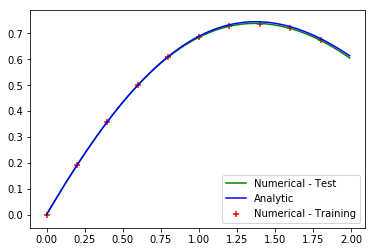

In [7]:
pred_train = ts.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test = ts(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
plt.plot(X_test, np.exp(-0.2*X_test)*np.sin(X_test), c='b', label='Analytic')
plt.legend()
plt.show()

Let's check the errors on the training set.

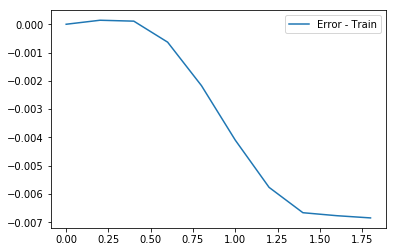

In [8]:
plt.plot(X_train, pred_train - np.exp(-0.2*X_train)*np.sin(X_train), label='Error - Train')
plt.legend()
plt.show()

Let's check the errors on the test set.

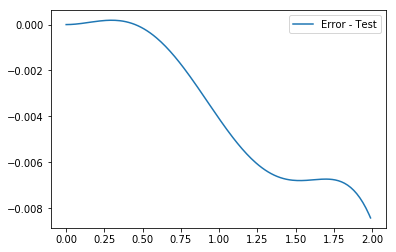

In [9]:
plt.plot(X_test, pred_test - np.exp(-0.2*X_test)*np.sin(X_test), label='Error - Test')
plt.legend()
plt.show()

The mean loss calculated on the test set.

In [10]:
diff_loss(ts, X_test).numpy().mean()

0.17204828078009635

Mean absolute error on the train set.

In [11]:
np.abs(pred_train - np.exp(-0.2*X_train)*np.sin(X_train)).mean()

0.003320540080081999

Mean absolute error on the test set - interpolation error.

In [12]:
np.abs(pred_test - np.exp(-0.2*X_test)*np.sin(X_test)).mean()

0.00369829523283011

In [13]:
np.abs(pred_test - np.exp(-0.2*X_test)*np.sin(X_test)).max()

0.008420814271365762